<h1 align=center><font size = 8>Identification of best possible areas in Moscow to open convenience stores</font></h1>

# Introduction

<img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Moscow-City_%2836211143494%29.jpg"/>

**Moscow** is the capital, most populous and extensively growing  city of Russia with over 15 millions of people within the city area. It is important financial and cultural center. As a representative of a big retail business, we want to access an opportunity to change our business model to opening convenience stores in highly populated city areas instead of opening new stores in large shopping malls which used to be popular several years ago. 

We want to be closer to our client by providing them ability to purchase everyday goods near their houses without necessity to visit shopping malls located far away from their residential areas. By using this approach, we also expect reducing of our rent payments and even more - we tend to consider spreading of convenience stores in Moscow as a part of our social responsibility - due to the fact that such business model brings not only convenience to our clients but at the same time it saves their personal time and reduces city daily traffic. 

In frame of this research we are going to segment city areas taking into account their population and number of stores that already exist in that area (they will be our competitors). For the research we made some assumptions:
* At first place, we are interested in areas with not only high population but high population density and lower amount of competitors. Such approach allows us to highlight the best possible areas to open new convenience stores
* We study only city area of Moscow without taking into account metropolitan one due to the same reason - population density and logistic issues

So, the main goal is to find new places for business expansion. 

# Toolbox & Data

After some investigation I have found out that there are no ready sets of open data that will fit our study. At first, we have to define data that we need, collect and prepare it and even produce new data. 

We will take a list of Moscow areas, their population and population density from the <a href="https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%80%D0%B0%D0%B9%D0%BE%D0%BD%D0%BE%D0%B2_%D0%B8_%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B">Wikipedia page.</a>  Please, don't pay attention to Cyrillic symbols at this moment is you don't understand russian. I will translate it during further data processing. Generally speaking, this table contains Moscow areas, their population and population density, etc.

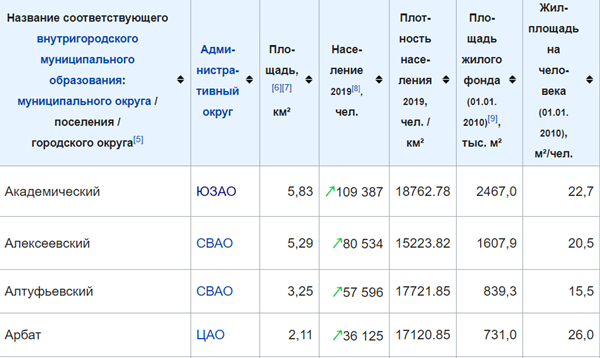

For our purposes, we will use the following toolbox:
* <font color="blue">Jupyter Notebook</font>  - to make the study, visualisation and reporting
* <font color="blue">Nominatim service</font> - to enrich our data set with geospatial coordinates 
* <font color="blue">Foursquare API v2</font> - for doing exploratory analysis, finding venues and explore moscow areas by geospatial coordinates 
* <font color="blue">Python and its libraries (like pandas, numpy, scikit-learn, etc.)</font> - for data processing and applying machine learning techniques 

# Data Preparation

## Getting and cleaning source data

As a first step of technical part of our work, we have to retrieve and prepare data. Let's get data set of moscow's districts and neighbourhoods from Wikipedia. 

In [1]:
%%capture 
#let's import and install required python libraries
!pip install BeautifulSoup4; #for dealing with XML and HTML
!pip install lxml
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [4]:
#let's get the list of Moscow districts and neighbourhoods
response = requests.get("https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%80%D0%B0%D0%B9%D0%BE%D0%BD%D0%BE%D0%B2_%D0%B8_%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B").text
soup = BeautifulSoup(response, 'lxml')

The next step is to clean the data that we have got and normilize them for further processing.

In [79]:
### we will delete columns that we are not inrested in
moscow_table = soup.find('table', {'class':'standard sortable'})
df = pd.read_html(str(moscow_table))[0]
headers = ['Num','Flag','Moto','Borough', 'Neighbourhood','Okrug','Square_KM2','Population','PopDensity_KM2','RE','REonPerson']
df.columns = headers
#drop extra columns that we will not use
df.drop(columns=['Num','Flag','Moto','Borough','Square_KM2','RE','REonPerson'], inplace = True)
#normalize data in columns
df.replace(to_replace=r'^↗|↘', value='', regex=True, inplace = True)
df.head(2)


,Neighbourhood,Okrug,Population,PopDensity_KM2
0,Академический,ЮЗАО,109 387,18762.78
1,Алексеевский,СВАО,80 534,15223.82


Then, we are going to exclude from our data set all **Okrugs** that are not belong to the central city part of Moscow. **Okrug** is name for large administrative division in slavic countries that includes districts.

In [80]:
#leave only central okrugs (drop all rows where Okrug in ('ТАО', 'НАО', 'ЗелАО'))

df = df[~df['Okrug'].isin(['ТАО','НАО','ЗелАО'])]
#check that everything is fine
df['Okrug'].unique()

array(['ЮЗАО', 'СВАО', 'ЦАО', 'САО', 'ЮАО', 'ВАО', 'ЗАО', 'ЮВАО', 'СЗАО'],
      dtype=object)

## Endriching data set with geospatial data

The next step is to add geospatial data - longtitude and latitide, as a separate columns to our data set. In order to do that, we will use **<font color="red">Nominatim</font>**

In [46]:
%%capture
#1. Install Nominatim
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

In [81]:
#2. Enrich the dataset with an artificial field wich will contain joint address sufficient to get coordinates from Nominatim
df['address'] = df['Neighbourhood']+', ' + df['Okrug']

#3. Enrich the dataset with longtitude and latitide coordinates
geolocator = Nominatim(user_agent="foursquare_agent")

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df['location'] = df['address'].apply(geocode)
df['lat'] = df['location'].apply(lambda loc: loc.point[0] if loc else None)
df['lon'] = df['location'].apply(lambda loc: loc.point[1] if loc else None)

#4. Let's see the result
df.head(3)

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon
0,Академический,ЮЗАО,109 387,18762.78,"Академический, ЮЗАО","(Академический, Москва, Юго-Западный администр...",55.689738,37.576771
1,Алексеевский,СВАО,80 534,15223.82,"Алексеевский, СВАО","(Алексеевский, Москва, Северо-Восточный админи...",55.814878,37.650668
2,Алтуфьевский,СВАО,57 596,17721.85,"Алтуфьевский, СВАО","(Алтуфьевский, Москва, Северо-Восточный админи...",55.880255,37.581635


Since we manage to get the final set of data which will be sufficient for our purposes I would like to preserve it as a separate file in order to secure the project from changing page markup in **Wikipedia** or from **Nominatim** service unavailability. As well, it will allow us not to repeat the same data processing steps every time when we restart session or reopen this Jupyter notebook.

In [49]:
%%capture
!pip install openpyxl

In [82]:
df.to_csv('moscow_df.csv', index=False)

In [2]:
df = pd.read_csv('moscow_df.csv')
df.head(2)

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon
0,Академический,ЮЗАО,109 387,18762.78,"Академический, ЮЗАО","Академический, Москва, Юго-Западный администра...",55.689738,37.576771
1,Алексеевский,СВАО,80 534,15223.82,"Алексеевский, СВАО","Алексеевский, Москва, Северо-Восточный админис...",55.814878,37.650668


# Methodology 
Since we have got and prepared all required data on Moscow neighborhoods the next step is to explore them and find all existing stores located in those areas. To do it we are going to use <a href="https://developer.foursquare.com/">API provided by Foursquare</a>.
We intend to analyze each area taking into account population density and number of convenience stores located in that area to identify sufficiency of such kind of store in concrete area. 

Then, we will use unsupervised machine learning algorithm <font color="blue">K-Means clustering</font> to cluster neighborhoods by criteria mentioned above and highlight best possible areas for business expansion.

### Assumptions
For purpose of our analysis we will calculate density of stores per 1000 inhabitants for each neighborhood. At the same time, we will count this parameter by calculating all stores localted within walking distance even if that store is in other neighborhood (people are not restricted by borders of theit neighborhood and they can visit them too if those stores are near their homes). 

### Applying Foursquare API to get data on location of convenience stores in th city neighbourhoods

To get required data from Foursquare we should invoke https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={} and pass all required parameters. 

This method takes unique identifier of venue category and returns all venues of such category located within radius for specific latitude and longitude coordinates. Foursquare API has broad range of categories that could be explored. All of them listed at <a href="https://developer.foursquare.com/docs/resources/categories">Foursquare developer portal</a>. 

<b>4d954b0ea243a5684a65b473</b> - is for convenience stores - the category that we are interested in. 

In [3]:
## At first, we need to get Foursquare credentials to connect
CLIENT_ID = 'BSG4WZUATSUUDOL2WSF22FDDJLXCIFYFYUMEVNGWE44011ES' # Foursquare ID
CLIENT_SECRET = 'BIQ3J2INYQ4RTZ4G2AT5ZW24GT2OQOG3D22HRMMNKC0ISIOG' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: BSG4WZUATSUUDOL2WSF22FDDJLXCIFYFYUMEVNGWE44011ES
CLIENT_SECRET:BIQ3J2INYQ4RTZ4G2AT5ZW24GT2OQOG3D22HRMMNKC0ISIOG


In [4]:
%%capture
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


In [10]:
#draw moscow map with neighbourhoods
# create map of Moscow using latitude and longitude values
latitude = 55.751244
longitude = 37.618423
map_moscow = folium.Map(location=[latitude, longitude], zoom_start=12, height=600, width=600)

# add markers to map
for lat, lng, okrug, neighborhood in zip(df['lat'], df['lon'], df['Okrug'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, okrug)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)  
    
map_moscow

In [11]:
#gets all venues of specific type (passes as parameter) within radius passed
#uses Foursquare API v2
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    return requests.get(explore_url).json()['response']['totalResults']

Let's get number of convinience stores for each neighbourhoods and calculate density of stores per 1000 inhabitants

In [13]:
#we will store it in new dataframe that is the copy of our source data + we will add calculated fields
final_df = df[:]
catId = '4d954b0ea243a5684a65b473' #convinience store API id

searchRadius = 1000

for i in range(len(final_df)):
    final_df.loc[i,'NumStores'] = int(get_venues_count(str(final_df.loc[i,'lat'])+', ' + str(final_df.loc[i,'lon']), radius = searchRadius, categoryId=catId))

#number of convinience stores per 1000 habitants    
for i in range(len(final_df)):
    final_df.loc[i,'StoresDens'] = final_df.loc[i,'NumStores']/final_df.loc[i,'PopDensity_KM2']*1000
    
final_df.head(2)

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon,NumStores,StoresDens
0,Академический,ЮЗАО,109 387,18762.78,"Академический, ЮЗАО","Академический, Москва, Юго-Западный администра...",55.689738,37.576771,9.0,0.479673
1,Алексеевский,СВАО,80 534,15223.82,"Алексеевский, СВАО","Алексеевский, Москва, Северо-Восточный админис...",55.814878,37.650668,6.0,0.394119


And one more trick is to convert cyrillic symbols into latin ones. 

In [2]:
%%capture
!pip install transliterate
from transliterate import translit, get_available_language_codes

In [8]:
for i in range(len(final_df)):
    final_df.loc[i, 'Neighbourhood'] = translit(final_df.loc[i, 'Neighbourhood'], reversed=True)
    final_df.loc[i, 'Okrug'] = translit(final_df.loc[i, 'Okrug'], reversed=True)
    final_df.loc[i, 'address'] = translit(final_df.loc[i, 'address'], reversed=True)
    final_df.loc[i, 'location'] = translit(final_df.loc[i, 'location'], reversed=True)
    
final_df.head()

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon,NumStores,StoresDens
0,Akademicheskij,JuZAO,109 387,18762.78,"Akademicheskij, JuZAO","Akademicheskij, Moskva, Jugo-Zapadnyj administ...",55.689738,37.576771,9.0,0.479673
1,Alekseevskij,SVAO,80 534,15223.82,"Alekseevskij, SVAO","Alekseevskij, Moskva, Severo-Vostochnyj admini...",55.814878,37.650668,6.0,0.394119
2,Altuf'evskij,SVAO,57 596,17721.85,"Altuf'evskij, SVAO","Altuf'evskij, Moskva, Severo-Vostochnyj admini...",55.880255,37.581635,8.0,0.451420
3,Arbat,TsAO,36 125,17120.85,"Arbat, TsAO","rajon Arbat, Tsentral'nyj administrativnyj okr...",55.751199,37.589872,5.0,0.292042
4,Aeroport,SAO,79 486,17355.02,"Aeroport, SAO","Aeroport, Leningradskij prospekt, Aeroport, ra...",55.800402,37.533156,14.0,0.806683


So, finally we have got the result set of data that will be enough for the purpose of our research. I will save it in cs 

In [9]:
#1. save final dataset to csv
final_df.to_csv('final_df.csv', index=False)

In [11]:
#2. load from csv
final_df = pd.read_csv('final_df.csv')
final_df.reset_index()
final_df.head(2)

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon,NumStores,StoresDens
0,Akademicheskij,JuZAO,109 387,18762.78,"Akademicheskij, JuZAO","Akademicheskij, Moskva, Jugo-Zapadnyj administ...",55.689738,37.576771,9.0,0.479673
1,Alekseevskij,SVAO,80 534,15223.82,"Alekseevskij, SVAO","Alekseevskij, Moskva, Severo-Vostochnyj admini...",55.814878,37.650668,6.0,0.394119


## Exploratory analysis

Let's take a look on our final dataset and try to get some insights from it. At first, we can seen that at least 60% of neighborhoods could be potential candidates for opening new convenience stores.

In [12]:
perc =[.20, .40, .60, .80]
final_df.describe(percentiles = perc)

,PopDensity_KM2,lat,lon,NumStores,StoresDens
count,120.000000,120.000000,120.000000,120.000000,120.000000
mean,13427.101583,55.750774,37.610057,6.266667,0.576184
std,5956.554925,0.091256,0.128955,3.499660,0.491926
min,559.870000,55.541272,37.300255,0.000000,0.000000
20%,8204.304000,55.664034,37.505995,4.000000,0.252855
40%,11273.844000,55.728329,37.572102,5.000000,0.359266
50%,13266.130000,55.751198,37.603425,6.000000,0.435175
60%,14627.228000,55.780270,37.639199,7.000000,0.531698
80%,17807.166000,55.839631,37.727509,8.000000,0.808530
max,30428.770000,55.936724,37.922905,17.000000,2.825956


Histogram and density plot produce the same insight. Despite the obvious outliers, most neighborhoods have insufficient number of convinience stores.  

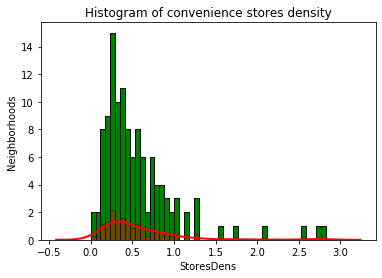

In [15]:
#рисуем гистограмму по плотности магазов по районам
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(final_df['StoresDens'], color = 'green', edgecolor = 'black',
         bins = int(120/2.5))

# seaborn histogram
sns.distplot(final_df['StoresDens'], hist=True, kde=False, 
             bins=int(120/2.5), color = 'green',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of convenience stores density')
plt.xlabel('Density')
plt.ylabel('Neighborhoods')

# Density Plot and Histogram
sns.distplot(final_df['StoresDens'], hist=True, kde=True, 
             bins=int(120/2.5), color = 'red', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

## Clustering

Finally, we will apply K-Means clustering to make a basic segmentation of Moscow neighborhoods based on convenience store density. We will use <b>scikit-learn</b> package and <b>folium</b> library to display the results. 

After several iterations of sampling and applying of clusterization, the number of k-Means clusters has been set to 5 to reflect more valuable results.



In [17]:
final_df.head()

,Neighbourhood,Okrug,Population,PopDensity_KM2,address,location,lat,lon,NumStores,StoresDens
0,Akademicheskij,JuZAO,109 387,18762.78,"Akademicheskij, JuZAO","Akademicheskij, Moskva, Jugo-Zapadnyj administ...",55.689738,37.576771,9.0,0.479673
1,Alekseevskij,SVAO,80 534,15223.82,"Alekseevskij, SVAO","Alekseevskij, Moskva, Severo-Vostochnyj admini...",55.814878,37.650668,6.0,0.394119
2,Altuf'evskij,SVAO,57 596,17721.85,"Altuf'evskij, SVAO","Altuf'evskij, Moskva, Severo-Vostochnyj admini...",55.880255,37.581635,8.0,0.451420
3,Arbat,TsAO,36 125,17120.85,"Arbat, TsAO","rajon Arbat, Tsentral'nyj administrativnyj okr...",55.751199,37.589872,5.0,0.292042
4,Aeroport,SAO,79 486,17355.02,"Aeroport, SAO","Aeroport, Leningradskij prospekt, Aeroport, ra...",55.800402,37.533156,14.0,0.806683


In [22]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

moscow_grouped_df = final_df.drop(final_df.columns[[0,1,2,3,4,5,8]], axis=1)

#final_df.drop(final_df.columns[[0]],axis=1, inplace=True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(moscow_grouped_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:9] 

array([3, 3, 3, 0, 4, 0, 3, 3, 0], dtype=int32)

In [23]:
# add clustering labels
moscow_grouped_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [26]:
%%capture
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [30]:
# create map
latitude = 55.751244
longitude = 37.618423
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, height =600, width = 600)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(moscow_grouped_df['lat'], moscow_grouped_df['lon'], moscow_grouped_df['StoresDens'], moscow_grouped_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results & Discussion

As we can see, there are lot of neighborhoods with quite low density of convenience stores. They are included in Cluster 0 and marked as red circles on the map above. And what is interesting is the fact that such neighborhoods are pretty much concentrated in south and north parts of Moscow.
* This observation allows us to consider those areas as the potential candidates for opening new stores
* Such concentration of neighborhoods with low stores density allows us to  implement effective logistic delivering model  and reduce the costs

Of course, there is a big potential for further analysis. E.g. we can add some other features to our model like real estate rent price, traffic data, etc. in order to investigate optimal places to start our expansion. But for this moment we have already got worthy insight in what direction we should move further.  

# Conclusion

During this project we applied different techniques and tools (Python,Foursquare API, web scrappling, etc.) to get required data, clean it, produce new one and make an analysis. We have managed to achieve the goal of our project and received valuable insights that potentially could bring real business benefit.

Full Jupyter notebook and data sets prepared during the project are available at GitHub.

Denis Shchuka, Feb 2020